In [1]:
!pip install -q tensorflow matplotlib seaborn tqdm

In [2]:
%env TF_XLA_FLAGS=--tf_xla_auto_jit=0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

env: TF_XLA_FLAGS=--tf_xla_auto_jit=0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
image_train_path = "/content/drive/MyDrive/Skripsi/Final/Split/Resized/Images/Train"
image_val_path   = "/content/drive/MyDrive/Skripsi/Final/Split/Resized/Images/Val"
image_test_path  = "/content/drive/MyDrive/Skripsi/Final/Split/Resized/Images/Test"

mask_train_path = "/content/drive/MyDrive/Skripsi/Final/Split/Resized/Labels/Train"
mask_val_path   = "/content/drive/MyDrive/Skripsi/Final/Split/Resized/Labels/Val"
mask_test_path  = "/content/drive/MyDrive/Skripsi/Final/Split/Resized/Labels/Test"

train_images = sorted([os.path.join(image_train_path, fname) for fname in os.listdir(image_train_path)])
train_masks  = sorted([os.path.join(mask_train_path, fname) for fname in os.listdir(mask_train_path)])

val_images = sorted([os.path.join(image_val_path, fname) for fname in os.listdir(image_val_path)])
val_masks  = sorted([os.path.join(mask_val_path, fname) for fname in os.listdir(mask_val_path)])

test_images = sorted([os.path.join(image_test_path, fname) for fname in os.listdir(image_test_path)])
test_masks  = sorted([os.path.join(mask_test_path, fname) for fname in os.listdir(mask_test_path)])


print("Jumlah data training:", len(train_images))
print("Jumlah data testing:", len(test_images))
print("JUmlah data validasi:", len(val_images))

Jumlah data training: 1183
Jumlah data testing: 338
JUmlah data validasi: 169


In [5]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 2  # Background + Tumor
BATCH_SIZE = 1
EPOCHS = 50
LEARNING_RATE = 1e-4

In [6]:
# Dataset Loader
def load_image_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = tf.image.convert_image_dtype(image, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.where(mask > 0.5, 1.0, 0.0)

    return image, mask

def get_dataset(image_paths, mask_paths, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = get_dataset(train_images, train_masks)
val_dataset = get_dataset(val_images, val_masks)
test_dataset = get_dataset(test_images, test_masks)

def generate_dummy_outputs(image, mask):
    batch_size = tf.shape(image)[0]

    dummy_rpn_class_logits = tf.zeros((batch_size, IMG_HEIGHT // 8, IMG_WIDTH // 8, 9), dtype=tf.float32)
    dummy_rpn_probs = tf.zeros((batch_size, IMG_HEIGHT // 8, IMG_WIDTH // 8, 9), dtype=tf.float32)
    dummy_rpn_bbox = tf.zeros((batch_size, IMG_HEIGHT // 8, IMG_WIDTH // 8, 36), dtype=tf.float32)
    dummy_class_logits = tf.zeros((batch_size, 32, NUM_CLASSES), dtype=tf.float32)
    dummy_bbox_fc = tf.zeros((batch_size, 32, NUM_CLASSES * 4), dtype=tf.float32)

    # Mask tidak perlu resize lagi
    resized_mask = mask
    resized_mask = tf.expand_dims(resized_mask, axis=-1)
    resized_mask = tf.tile(resized_mask, [1, 1, 1, NUM_CLASSES])

    return image, (dummy_rpn_class_logits, dummy_rpn_probs, dummy_rpn_bbox, dummy_class_logits, dummy_bbox_fc, resized_mask)

In [7]:
# Datasets
train_dataset = get_dataset(train_images, train_masks)
val_dataset = get_dataset(val_images, val_masks)
test_dataset = get_dataset(test_images, test_masks)

In [8]:
# Model Components
def build_backbone_fpn():
    base_model = keras.applications.ResNet50(include_top=False, input_shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    c3_output = base_model.get_layer("conv3_block4_out").output
    c4_output = base_model.get_layer("conv4_block6_out").output
    c5_output = base_model.get_layer("conv5_block3_out").output

    p5 = layers.Conv2D(256, 1)(c5_output)
    p4 = layers.Add()([
        layers.UpSampling2D()(p5),
        layers.Conv2D(256, 1)(c4_output)
    ])
    p3 = layers.Add()([
        layers.UpSampling2D()(p4),
        layers.Conv2D(256, 1)(c3_output)
    ])
    p3 = layers.Conv2D(256, 3, padding="same")(p3)
    p4 = layers.Conv2D(256, 3, padding="same")(p4)
    p5 = layers.Conv2D(256, 3, padding="same")(p5)

    return keras.Model(inputs=base_model.input, outputs=[p3, p4, p5])

In [9]:
def build_rpn():
    input_feature = layers.Input(shape=[None, None, 256])
    shared = layers.Conv2D(256, 3, padding="same", activation="relu")(input_feature)
    rpn_class_logits = layers.Conv2D(9, 1)(shared)
    rpn_probs = layers.Activation("sigmoid")(rpn_class_logits)
    rpn_bbox = layers.Conv2D(9 * 4, 1)(shared)
    return keras.Model(inputs=input_feature, outputs=[rpn_class_logits, rpn_probs, rpn_bbox])

In [10]:
class ROIAlign(layers.Layer):
    def __init__(self, pool_size):
        super(ROIAlign, self).__init__()
        self.pool_size = pool_size

    def call(self, inputs):
        feature_maps, proposals = inputs

        batch_size = tf.shape(feature_maps)[0]
        num_proposals = tf.shape(proposals)[1]

        proposals = tf.reshape(proposals, [batch_size * num_proposals, 4])

        y1 = proposals[:, 0]
        x1 = proposals[:, 1]
        y2 = proposals[:, 2]
        x2 = proposals[:, 3]

        y1 = tf.minimum(y1, y2)
        y2 = tf.maximum(y1, y2)
        x1 = tf.minimum(x1, x2)
        x2 = tf.maximum(x1, x2)

        proposals = tf.stack([y1, x1, y2, x2], axis=1)
        proposals = tf.clip_by_value(proposals, 0.0, 1.0)

        box_indices = tf.repeat(tf.range(batch_size), num_proposals)

        rois = tf.image.crop_and_resize(
            feature_maps,
            boxes=proposals,
            box_indices=box_indices,
            crop_size=self.pool_size
        )

        channels = tf.shape(feature_maps)[-1]
        rois = tf.reshape(rois, [batch_size, num_proposals, self.pool_size[0], self.pool_size[1], channels])

        return rois

In [11]:
def build_detection_head(pool_size, num_classes):
    inputs = layers.Input(shape=(pool_size, pool_size, 256))
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dense(1024, activation="relu")(x)
    class_logits = layers.Dense(num_classes)(x)
    bbox_fc = layers.Dense(num_classes * 4)(x)
    return keras.Model(inputs, outputs=[class_logits, bbox_fc])

def build_mask_head(pool_size, num_classes):
    inputs = layers.Input(shape=(pool_size, pool_size, 256))
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    mask = layers.Conv2D(num_classes, 1, activation="sigmoid")(x)

    mask = layers.Resizing(IMG_HEIGHT, IMG_WIDTH, interpolation="bilinear")(mask)
    return keras.Model(inputs, mask)

In [12]:
# Build Full Model
backbone = build_backbone_fpn()
rpn_model = build_rpn()
roi_align = ROIAlign(pool_size=(14, 14))
detection_head = build_detection_head(14, NUM_CLASSES)
mask_head = build_mask_head(pool_size=14, num_classes=1)

input_image = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
feature_maps = backbone(input_image)
rpn_class_logits, rpn_probs, rpn_bbox = rpn_model(feature_maps[0])

proposals = layers.Lambda(lambda x: tf.random.uniform((tf.shape(x)[0], 16, 4), minval=0, maxval=1))(input_image)

@tf.function(jit_compile=False)
def roi_align_fn(inputs):
    return roi_align(inputs)

rois = roi_align([feature_maps[0], proposals])
rois = layers.Lambda(lambda x: tf.reshape(x, (-1, x.shape[2], x.shape[3], x.shape[4])))(rois)

class_logits, bbox_fc = detection_head(rois)
mask = mask_head(rois)

model = models.Model(inputs=input_image, outputs=[mask])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    jit_compile=False
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 32, 32,   │ 26,276,224 │ input_layer_4[0]… │
│ (Functional)        │ 256), (None, 16,  │            │                   │
│                     │ 16, 256), (None,  │            │                   │
│                     │ 8, 8, 256)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 16, 4)     │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ roi_align           │ (None, 16, 14,    │          0 │ functional[0][0], │
│ (ROIAlign)          │ 14, 256)          │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 14, 14,    │          0 │ roi_align[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 256, 256,  │  2,360,577 │ lambda_1[0][0]    │
│ (Functional)        │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,636,801 (109.24 MB)

 Trainable params: 28,583,681 (109.04 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=EPOCHS)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['conv2d_4/kernel', 'conv2d_4/bias', 'conv2d_5/kernel', 'conv2d_5/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


1183/1183 ━━━━━━━━━━━━━━━━━━━━ 223s 149ms/step - loss: 0.1917 - val_loss: 0.1679
Epoch 2/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 132s 112ms/step - loss: 0.1600 - val_loss: 0.1581
Epoch 3/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 133s 112ms/step - loss: 0.1538 - val_loss: 0.1569
Epoch 4/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 133s 112ms/step - loss: 0.1505 - val_loss: 0.1605
Epoch 5/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 133s 112ms/step - loss: 0.1497 - val_loss: 0.1566
Epoch 6/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 133s 112ms/step - loss: 0.1487 - val_loss: 0.1559
Epoch 7/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 133s 113ms/step - loss: 0.1502 - val_loss: 0.1550
Epoch 8/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 135s 114ms/step - loss: 0.1453 - val_loss: 0.1566
Epoch 9/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 132s 112ms/step - loss: 0.1495 - val_loss: 0.1565
Epoch 10/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 132s 111ms/step - loss: 0.1472 - val_loss: 0.1551
Epoch 11/50
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 132s 112ms/step - loss: 0.1469 - val_loss: 0.15

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.0
Recall: 0.0
F1 Score: 0.0


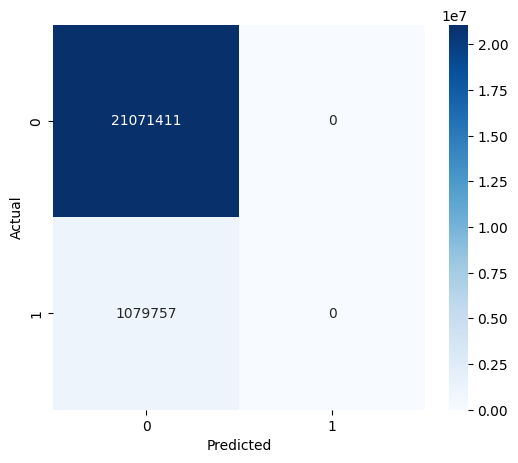

In [19]:
# Evaluation
# Load True Mask
y_true = []
for mask_path in test_masks:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = (mask > 127).astype(int)
    y_true.extend(mask.flatten())

# Predict
y_pred = []
for image_path in test_images:
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)

    pred_mask = model.predict(image)[0]
    pred_mask = (pred_mask > 0.5).astype(int)

    y_pred.extend(pred_mask.flatten())

# Metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


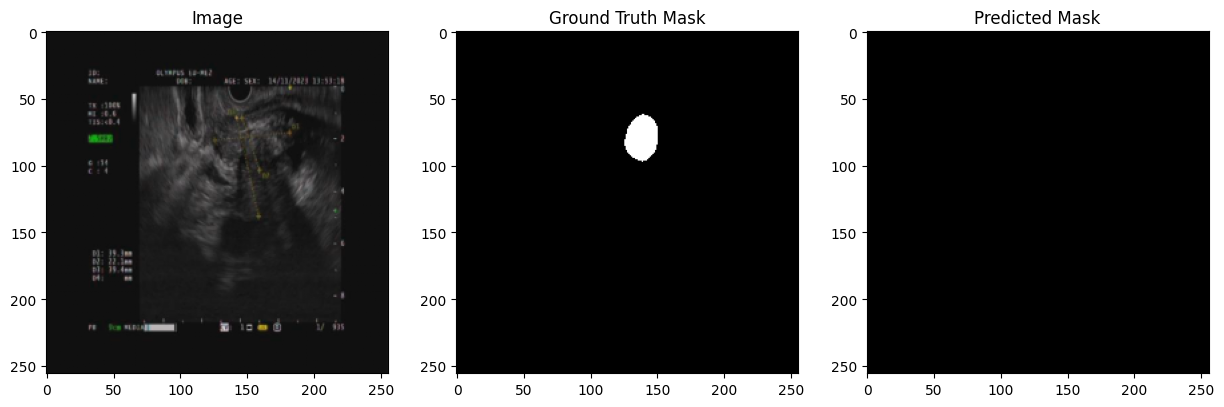

In [20]:
# Visualize Prediction
sample_image = cv2.imread(test_images[0])
sample_image = cv2.resize(sample_image, (IMG_WIDTH, IMG_HEIGHT))
sample_image = sample_image / 255.0  # <<<<<< Tambahkan normalisasi

sample_image_input = np.expand_dims(sample_image, axis=0)
pred_mask = model.predict(sample_image_input)[0]
pred_mask = (pred_mask > 0.5).astype(int)

true_mask = cv2.imread(test_masks[0], cv2.IMREAD_GRAYSCALE)
true_mask = cv2.resize(true_mask, (IMG_WIDTH, IMG_HEIGHT))
true_mask = (true_mask > 127).astype(int)

sample_image_input = np.expand_dims(sample_image, axis=0)
pred_mask = model.predict(sample_image_input)[0]
pred_mask = (pred_mask > 0.5).astype(int)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(sample_image)
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(true_mask, cmap="gray")
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(pred_mask.squeeze(), cmap="gray")
plt.title("Predicted Mask")
plt.show()

In [21]:
# Dice Coefficient Calculation
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    y_pred_binary = (y_pred > 0.5).astype(np.float32)

    y_true_f = y_true.flatten()
    y_pred_f = y_pred_binary.flatten()

    intersection = np.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

    return dice

# Dice Score Evaluation
sample_image = cv2.imread(test_images[0])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = cv2.resize(sample_image, (IMG_WIDTH, IMG_HEIGHT)) # Resize to match model input
sample_image = sample_image.astype(np.float32) / 255.0

true_mask = cv2.imread(test_masks[0], cv2.IMREAD_GRAYSCALE)
true_mask = (true_mask > 127).astype(np.float32)

pred_mask = model.predict(np.expand_dims(sample_image, 0))[-1][0]

if pred_mask.shape != true_mask.shape:
    true_mask = cv2.resize(true_mask, (pred_mask.shape[1], pred_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

dice_score = dice_coefficient(true_mask, pred_mask)

print(f"Dice Coefficient: {dice_score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Dice Coefficient: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Dice Coefficient: 0.0000


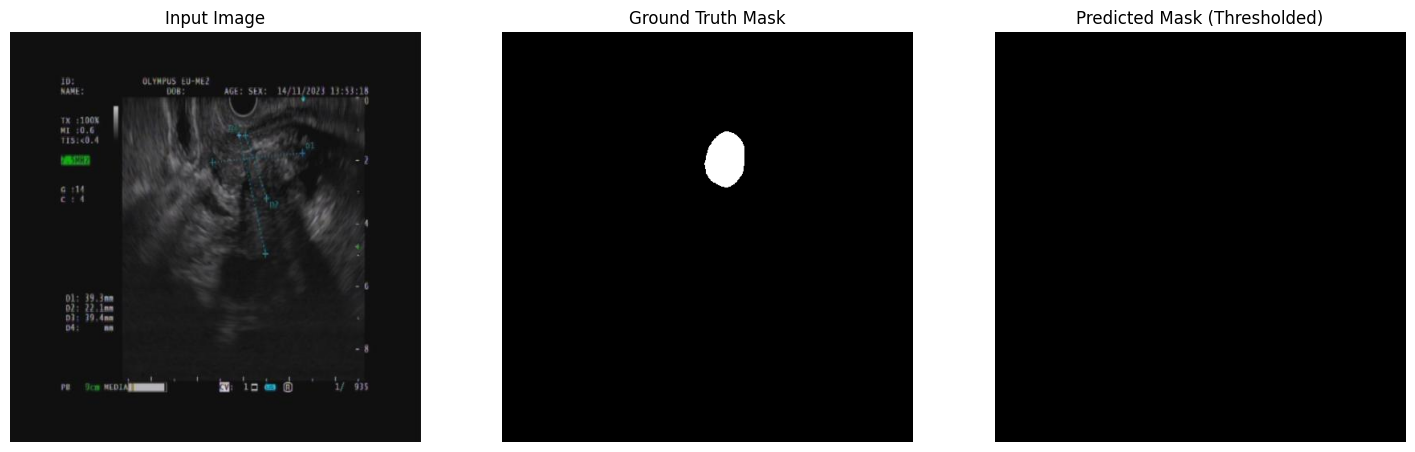

In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Dice Coefficient function
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)

    # Binarize prediction
    y_pred_binary = (y_pred > 0.5).astype(np.float32)

    # Flatten arrays
    y_true_f = y_true.flatten()
    y_pred_f = y_pred_binary.flatten()

    intersection = np.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

    return dice

# Load sample image and ground truth mask
sample_image = cv2.imread(test_images[0])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = sample_image.astype(np.float32) / 255.0

true_mask = cv2.imread(test_masks[0], cv2.IMREAD_GRAYSCALE)
true_mask = (true_mask > 127).astype(np.float32)

# Predict mask from model
pred_mask = model.predict(np.expand_dims(sample_image, 0))[-1][0]

# Resize prediction if needed
if pred_mask.shape[:2] != true_mask.shape[:2]:
    pred_mask_resized = cv2.resize(pred_mask.squeeze(), (true_mask.shape[1], true_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
else:
    pred_mask_resized = pred_mask.squeeze()

# Binarize pred_mask_resized for dice calculation
pred_mask_binary = (pred_mask_resized > 0.5).astype(np.float32)

# Compute Dice Coefficient
dice_score = dice_coefficient(true_mask, pred_mask_binary)
print(f"Dice Coefficient: {dice_score:.4f}")

# Visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(sample_image)
axs[0].set_title('Input Image')
axs[0].axis('off')

axs[1].imshow(true_mask, cmap='gray')
axs[1].set_title('Ground Truth Mask')
axs[1].axis('off')

axs[2].imshow(pred_mask_binary, cmap='gray')
axs[2].set_title('Predicted Mask (Thresholded)')
axs[2].axis('off')

plt.show()
